# Self Attention Mechanism for Image Processing

## Brief Recap of Self-Attention in Computer Vision

- Self-attention mechanisms have revolutionized how we process visual data by enabling models to focus on relevant parts of an image while considering spatial relationships. 

- Unlike traditional convolutional neural networks that process images using fixed-size kernels, self-attention allows for dynamic, content-dependent processing of visual information.

- In the context of image processing, self-attention operates on patches or regions of an image, allowing each part to interact with every other part. This enables the model to capture both local details and global context simultaneously.

## Architecture of Visual Self-Attention

When applying self-attention to images, we need to consider several key components:

### Image Tokenization

Before applying self-attention, we first need to convert our image into a sequence of tokens. This is typically done by:
1. Dividing the image into fixed-size patches (e.g., 16x16 pixels)
2. Flattening each patch into a 1D vector
3. Projecting these vectors into a lower-dimensional embedding space

For an image of size H×W×C (Height × Width × Channels), divided into P×P patches, we get:
- Number of patches: N = (H×W)/(P×P)
- Each patch vector: P×P×C dimensions
- Final sequence length: N tokens

### Query, Key, and Value Representations

Each image patch token is transformed into three representations:
- Query (Q): Represents what the current patch is "looking for"
- Key (K): Represents what other patches offer
- Value (V): Represents the actual content to be aggregated

The mathematical formulation remains similar to text processing:
```
Attention(Q, K, V) = softmax(QK^T/√d_k)V
```

Where d_k is the dimension of the key vectors.

## Implementation with TensorFlow

Let's create a custom Visual Attention layer that can process image data:

In [1]:
import tensorflow as tf


class VisualAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, projection_dim, transformer_units):
        super().__init__()
        self.num_heads = num_heads
        self.projection_dim = projection_dim
        
        # Convert transformer_units to integer if it's a list
        if isinstance(transformer_units, list):
            self.transformer_units = transformer_units[0]
        else:
            self.transformer_units = transformer_units
        
        # Multi-head attention layer
        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim,
            dropout=0.1
        )
        
        # Feedforward network
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(self.transformer_units, activation="gelu"),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(projection_dim)
        ])
        
        # Layer normalization
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        # Add layers for residual connections
        self.add1 = tf.keras.layers.Add()
        self.add2 = tf.keras.layers.Add()
        
    def build(self, input_shape):
        super().build(input_shape)
    
    def compute_output_shape(self, input_shape):
        return input_shape
    
    def call(self, inputs, training=None):
        # First layer normalization and attention
        x1 = self.layernorm1(inputs)
        attention_output = self.mha(x1, x1, x1, training=training)
        
        # First residual connection
        x2 = self.add1([attention_output, inputs])
        
        # Second layer normalization and feedforward network
        x3 = self.layernorm2(x2)
        x4 = self.ffn(x3, training=training)
        
        # Second residual connection
        return self.add2([x2, x4])
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_heads": self.num_heads,
            "projection_dim": self.projection_dim,
            "transformer_units": self.transformer_units,
        })
        return config

2024-12-29 13:22:37.181461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735496557.202245 2516231 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735496557.208716 2516231 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-29 13:22:37.229273: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Code Explanation:**


The VisualAttention class is a custom layer that implements the self-attention mechanism specifically for image processing. Let's examine each part:

First, let's look at the class initialization:
```python
def __init__(self, num_heads, projection_dim, transformer_units):
    super().__init__()
    self.num_heads = num_heads
    self.projection_dim = projection_dim
    
    # Convert transformer_units to integer if it's a list
    if isinstance(transformer_units, list):
        self.transformer_units = transformer_units[0]
    else:
        self.transformer_units = transformer_units
```
This part sets up the basic parameters of our attention mechanism. The `num_heads` parameter allows the attention layer to learn different types of relationships in parallel - imagine having multiple specialists each focusing on different aspects of the image. The `projection_dim` determines the size of our feature space, while `transformer_units` controls the size of our feedforward network.

Next, we create the main components:
```python
# Multi-head attention layer
self.mha = tf.keras.layers.MultiHeadAttention(
    num_heads=num_heads,
    key_dim=projection_dim,
    dropout=0.1
)
```
This creates the multi-head attention mechanism. Think of it like having multiple sets of eyes looking at the same image, each set focusing on different relationships between parts of the image. The dropout helps prevent overfitting by randomly "turning off" some connections during training.

```python
# Feedforward network
self.ffn = tf.keras.Sequential([
    tf.keras.layers.Dense(self.transformer_units, activation="gelu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(projection_dim)
])
```
The feedforward network processes the attention output further. It first expands the representation (usually to a larger size) using the first Dense layer, applies a GELU activation for non-linearity, and then projects back to our original dimension. This allows the network to capture more complex relationships in the data.

The normalization layers and residual connections are crucial for stable training:
```python
# Layer normalization
self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

# Add layers for residual connections
self.add1 = tf.keras.layers.Add()
self.add2 = tf.keras.layers.Add()
```
Layer normalization helps control the scale of our features throughout the network. The residual connections (implemented through the Add layers) allow the network to preserve important information from earlier layers and help with gradient flow during training.

The core processing happens in the call method:
```python
def call(self, inputs, training=None):
    # First layer normalization and attention
    x1 = self.layernorm1(inputs)
    attention_output = self.mha(x1, x1, x1, training=training)
    
    # First residual connection
    x2 = self.add1([attention_output, inputs])
    
    # Second layer normalization and feedforward network
    x3 = self.layernorm2(x2)
    x4 = self.ffn(x3, training=training)
    
    # Second residual connection
    return self.add2([x2, x4])
```
This implements what's known as a transformer block. The process flows like this:
1. Normalize the input
2. Apply self-attention (notice we use the same input three times for query, key, and value)
3. Add the attention output to the original input (first residual connection)
4. Normalize again
5. Process through the feedforward network
6. Add another residual connection

The additional methods ensure proper Keras integration:
```python
def build(self, input_shape):
    super().build(input_shape)

def compute_output_shape(self, input_shape):
    return input_shape

def get_config(self):
    config = super().get_config()
    config.update({
        "num_heads": self.num_heads,
        "projection_dim": self.projection_dim,
        "transformer_units": self.transformer_units,
    })
    return config
```
These methods handle shape inference, layer building, and serialization, making the layer behave properly within the Keras framework.

## Real-world Project: Image Classification with Visual Attention

Let's build a complete image classification model using visual attention. We'll use the CIFAR-10 dataset as an example.


### Data Preparation

In [2]:
from tensorflow.keras.datasets import cifar10

# Load and preprocess CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

### Patch Creation and Embedding

In [3]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, patch_size, projection_dim):
        super().__init__()
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.projection = tf.keras.layers.Dense(projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=((32 // patch_size) ** 2),
            output_dim=projection_dim
        )

    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=patches.shape[1], delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

### Complete Model Architecture

In [4]:
def create_vision_transformer(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_transformer_blocks,
    num_heads,
    transformer_units,
    num_classes,
):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Create patches - first reshape the image into patches
    patch_dim = patch_size * patch_size * input_shape[-1]
    patches = tf.keras.layers.Reshape((num_patches, patch_dim))(inputs)
    
    # Create patch embedding
    x = tf.keras.layers.Dense(projection_dim)(patches)
    
    # Add position embeddings
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = tf.keras.layers.Embedding(
        input_dim=num_patches, 
        output_dim=projection_dim
    )(positions)
    x = x + position_embedding
    
    # Create transformer blocks
    for _ in range(num_transformer_blocks):
        attention_block = VisualAttention(
            num_heads=num_heads,
            projection_dim=projection_dim,
            transformer_units=transformer_units
        )
        x = attention_block(x)
    
    # Create classifier head
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(projection_dim, activation="gelu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

### Training the Model

In [5]:
# Model hyperparameters
patch_size = 4
num_patches = (32 // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
num_transformer_blocks = 4

# Create and compile model
model = create_vision_transformer(
    input_shape=(32, 32, 3),
    patch_size=patch_size,
    num_patches=num_patches,
    projection_dim=projection_dim,
    num_transformer_blocks=num_transformer_blocks,
    num_heads=num_heads,
    transformer_units=transformer_units,
    num_classes=10,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2),
    ],
)

I0000 00:00:1735496591.667805 2516231 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11437 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:04:00.0, compute capability: 6.0


Epoch 1/20


I0000 00:00:1735496606.644430 2516276 service.cc:148] XLA service 0x15074000e5f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735496606.644464 2516276 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-12GB, Compute Capability 6.0
2024-12-29 13:23:26.953823: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735496608.256349 2516276 cuda_dnn.cc:529] Loaded cuDNN version 90300


  21/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.0988 - loss: 2.5078  

I0000 00:00:1735496616.020077 2516276 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.1807 - loss: 2.1765 - val_accuracy: 0.2716 - val_loss: 1.9046 - learning_rate: 0.0010
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.2956 - loss: 1.8908 - val_accuracy: 0.3238 - val_loss: 1.8532 - learning_rate: 0.0010
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3258 - loss: 1.8071 - val_accuracy: 0.3662 - val_loss: 1.7153 - learning_rate: 0.0010
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.3476 - loss: 1.7462 - val_accuracy: 0.3894 - val_loss: 1.6433 - learning_rate: 0.0010
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.3808 - loss: 1.6898 - val_accuracy: 0.3960 - val_loss: 1.6332 - learning_rate: 0.0010
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3954 - loss: 1.6528 - val_accuracy: 0.4158 - val_loss: 1.5975 - learning_rate: 0.0010
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4118 - loss

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5061 - loss: 1.3834
Test accuracy: 0.5012
Test loss: 1.3919
Generating training history plots...


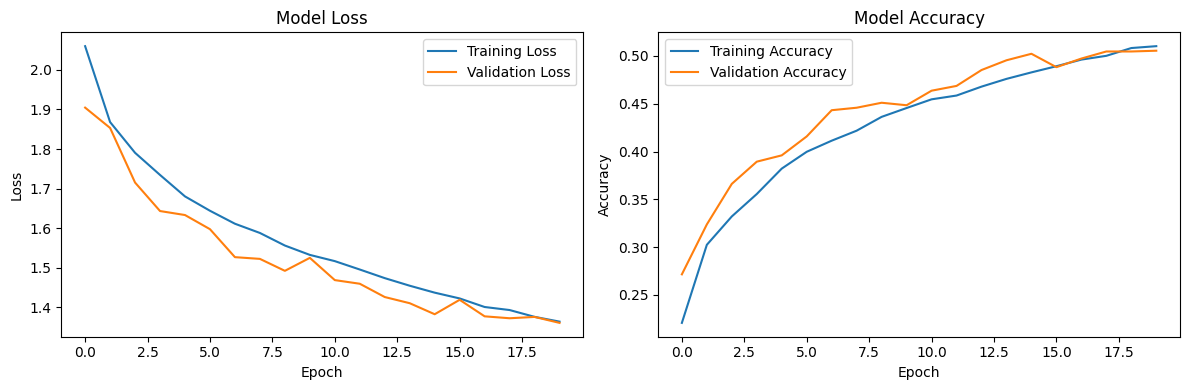

In [14]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Plot and save training history
print("Generating training history plots...")
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

## Key Differences from Text-Based Attention

When working with images, several unique considerations arise:

1. **Spatial Information**: Images have inherent 2D structure that needs to be preserved
2. **Local Dependencies**: Unlike text, images often have strong local dependencies
3. **Computational Complexity**: The quadratic complexity of attention becomes more challenging with high-resolution images
4. **Position Encoding**: 2D position information needs to be encoded differently from 1D text sequences

## Applications of Visual Self-Attention

Visual self-attention has enabled breakthroughs in various computer vision tasks:

1. Image Classification
2. Object Detection
3. Semantic Segmentation
4. Image Generation
5. Video Understanding
6. Medical Image Analysis
7. Scene Understanding
8. Visual Question Answering

Each of these applications leverages attention's ability to capture long-range dependencies and focus on relevant image regions while maintaining spatial awareness.